In [1]:
import numpy as np
import matplotlib.pyplot as plt
import copy
import seaborn as sns

In [8]:
import torch
import torchvision.models as models
import torchvision.transforms as transforms
from PIL import Image
from sklearn.decomposition import PCA

In [18]:
mmpose_data = np.load('world_pred1_mmpose.npy')

In [17]:
ans = []
for each in data:
    ans.append(each[:3])

from collections import Counter

print(len(Counter(ans)))
    

27


In [11]:
# 加载预训练的ResNet模型
model = models.resnet50(pretrained=True)
model.eval()

# 图像预处理
transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# 加载图像并预处理
image = Image.open('../../roi_seg/segformer/img/v01_ctd001th.jpg')
image = transform(image).unsqueeze(0)  # 增加批次维度

# 提取特征
with torch.no_grad():
    features = model(image)
features = features.squeeze().numpy()

print(features.shape)
# PCA降维到3个维度
pca = PCA(n_components=3)
features_pca = pca.fit_transform(features.reshape(1, -1))

# 可视化
plt.imshow(features_pca.reshape(224, 224, 3))
# plt.show()

D:\appliction\anaconda\envs\seg\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
D:\appliction\anaconda\envs\seg\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


(1000,)


ValueError: n_components=3 must be between 0 and min(n_samples, n_features)=1 with svd_solver='full'

In [42]:
def world_all_releated():
    all_datas = []
    for points in ['lp0', 'lp1', 'lp2', 'lp3', 'rp0', 'rp1', 'rp2', 'rp3']:
        with open(f"action_data/{points}_positions.txt") as f:
            data = f.readlines()
            temp_loc = []
            for ee in data:
                # print(ee)
                wx = float(ee.split(';')[0].split(',')[0])
                wy = float(ee.split(';')[0].split(',')[1])
                wz = float(ee.split(';')[0].split(',')[2])
                temp_loc.append([wx, wy, wz])
            all_datas.append(copy.copy(temp_loc))

    all_datas = np.array(all_datas)
    gt_left_data = all_datas[4:]
    gt_right_data = all_datas[:4]

    left_data = np.load('left_tool_world.npy')
    right_data = np.load('right_tool_world.npy')

    xyz_err = np.zeros([140,8,3])
    euler_err = np.zeros([140,8])
    for ii in range(140):
        # gt left
        xs = gt_left_data[:, ii, 0]
        ys = gt_left_data[:, ii, 1]
        zs = gt_left_data[:, ii, 2]
        zs, ys = ys, zs
        
        gt_left_x = copy.copy(xs)
        gt_left_y = copy.copy(ys)
        gt_left_z = copy.copy(zs)
        

        # gt right
        xs = gt_right_data[:, ii, 0]
        ys = gt_right_data[:, ii, 1]
        zs = gt_right_data[:, ii, 2]
        zs, ys = ys, zs
        gt_right_x = copy.copy(xs)
        gt_right_y = copy.copy(ys)
        gt_right_z = copy.copy(zs)
        # ===========================================
        
        # compensate_x = gt_left_data[3,ii,0] - left_data[ii,3,0]
        # compensate_y = gt_left_data[3,ii,2] - -left_data[ii,3,2]
        compensate_x = 0
        compensate_y = 0
        compensate_z = gt_right_data[0,ii,1] - -right_data[ii,0,1]
        
        # pred left
        xs = left_data[ii,:,0]
        ys = -left_data[ii,:,1]
        zs = -left_data[ii,:,2]
        zs,ys = ys, zs
        pred_left_x = copy.copy(xs) + compensate_x
        pred_left_y = copy.copy(ys) + compensate_y
        pred_left_z = copy.copy(zs) + compensate_z
        
 
        # pred right
        xs = right_data[ii,:,0]
        ys = -right_data[ii,:,1]
        zs = -right_data[ii,:,2]
        zs, ys = ys, zs
        pred_right_x = copy.copy(xs) + compensate_x
        pred_right_y = copy.copy(ys) + compensate_y
        pred_right_z = copy.copy(zs) + compensate_z
        
        # print(pred_left_x.shape)
        
        xyz_err[ii,:4,0] = gt_left_x - pred_left_x
        xyz_err[ii,:4,1] = gt_left_y - pred_left_y
        xyz_err[ii,:4,2] = gt_left_z - pred_left_z
        
        xyz_err[ii,4:,0] = gt_right_x - pred_right_x
        xyz_err[ii,4:,1] = gt_right_y - pred_right_y
        xyz_err[ii,4:,2] = gt_right_z - pred_right_z
        
        
        
        euler_err[ii,:4] = np.sqrt((pred_left_x - gt_left_x)**2 +
                             (pred_left_y - gt_left_y)**2 + (pred_left_z - gt_left_z)**2)
        
        euler_err[ii,4:] = np.sqrt((pred_right_x - gt_right_x)**2 +
                             (pred_right_y - gt_right_y)**2 + (pred_right_z - gt_right_z)**2)
    
    return xyz_err, euler_err

In [23]:
def world_all():
    all_datas = []
    for points in ['lp0', 'lp1', 'lp2', 'lp3', 'rp0', 'rp1', 'rp2', 'rp3']:
        with open(f"action_data/{points}_positions.txt") as f:
            data = f.readlines()
            temp_loc = []
            for ee in data:
                # print(ee)
                wx = float(ee.split(';')[0].split(',')[0])
                wy = float(ee.split(';')[0].split(',')[1])
                wz = float(ee.split(';')[0].split(',')[2])
                temp_loc.append([wx, wy, wz])
            all_datas.append(copy.copy(temp_loc))

    all_datas = np.array(all_datas)
    gt_left_data = all_datas[4:]
    gt_right_data = all_datas[:4]

    left_data = np.load('left_tool_world.npy')
    right_data = np.load('right_tool_world.npy')

    xyz_err = np.zeros([140,8,3])
    euler_err = np.zeros([140,8])
    for ii in range(140):
        # gt left
        xs = gt_left_data[:, ii, 0]
        ys = gt_left_data[:, ii, 1]
        zs = gt_left_data[:, ii, 2]
        zs, ys = ys, zs
        
        gt_left_x = copy.copy(xs)
        gt_left_y = copy.copy(ys)
        gt_left_z = copy.copy(zs)
        

        # gt right
        xs = gt_right_data[:, ii, 0]
        ys = gt_right_data[:, ii, 1]
        zs = gt_right_data[:, ii, 2]
        zs, ys = ys, zs
        gt_right_x = copy.copy(xs)
        gt_right_y = copy.copy(ys)
        gt_right_z = copy.copy(zs)

        # pred left
        xs = left_data[ii,:,0]
        ys = -left_data[ii,:,1]
        zs = -left_data[ii,:,2]
        zs,ys = ys, zs
        pred_left_x = copy.copy(xs)
        pred_left_y = copy.copy(ys)
        pred_left_z = copy.copy(zs)
 
        # pred right
        xs = right_data[ii,:,0]
        ys = -right_data[ii,:,1]
        zs = -right_data[ii,:,2]
        zs, ys = ys, zs
        pred_right_x = copy.copy(xs)
        pred_right_y = copy.copy(ys)
        pred_right_z = copy.copy(zs)
        
        # print(pred_left_x.shape)
        
        xyz_err[ii,:4,0] = gt_left_x - pred_left_x
        xyz_err[ii,:4,1] = gt_left_y - pred_left_y
        xyz_err[ii,:4,2] = gt_left_z - pred_left_z
        
        xyz_err[ii,4:,0] = gt_right_x - pred_right_x
        xyz_err[ii,4:,1] = gt_right_y - pred_right_y
        xyz_err[ii,4:,2] = gt_right_z - pred_right_z
        
        
        
        euler_err[ii,:4] = np.sqrt((pred_left_x - gt_left_x)**2 +
                             (pred_left_y - gt_left_y)**2 + (pred_left_z - gt_left_z)**2)
        
        euler_err[ii,4:] = np.sqrt((pred_right_x - gt_right_x)**2 +
                             (pred_right_y - gt_right_y)**2 + (pred_right_z - gt_right_z)**2)
    
    return xyz_err, euler_err

In [39]:
def world_all_mmpose():
    all_datas = []
    for points in ['lp0', 'lp1', 'lp2', 'lp3', 'rp0', 'rp1', 'rp2', 'rp3']:
        with open(f"action_data/{points}_positions.txt") as f:
            data = f.readlines()
            temp_loc = []
            for ee in data:
                # print(ee)
                wx = float(ee.split(';')[0].split(',')[0])
                wy = float(ee.split(';')[0].split(',')[1])
                wz = float(ee.split(';')[0].split(',')[2])
                temp_loc.append([wx, wy, wz])
            all_datas.append(copy.copy(temp_loc))

    all_datas = np.array(all_datas)
    gt_left_data = all_datas[4:]
    gt_right_data = all_datas[:4]

    pred_data = np.load('world_pred1_mmpose.npy')
    # right_data = np.load('right_tool_world.npy')

    xyz_err = np.zeros([140,8,3])
    euler_err = np.zeros([140,8])
    for ii in range(140):
        # gt left
        xs = gt_left_data[:, ii, 0]
        ys = gt_left_data[:, ii, 1]
        zs = gt_left_data[:, ii, 2]
        zs, ys = ys, zs
        
        gt_left_x = copy.copy(xs)
        gt_left_y = copy.copy(ys)
        gt_left_z = copy.copy(zs)
        

        # gt right
        xs = gt_right_data[:, ii, 0]
        ys = gt_right_data[:, ii, 1]
        zs = gt_right_data[:, ii, 2]
        zs, ys = ys, zs
        gt_right_x = copy.copy(xs)
        gt_right_y = copy.copy(ys)
        gt_right_z = copy.copy(zs)
        # ===========================================
        
        
        # pred right
        xs = pred_data[ii,:4,0]
        ys = pred_data[ii,:4,1]
        zs = pred_data[ii,:4,2]
        zs,ys = ys, zs
        pred_right_x = copy.copy(xs)
        pred_right_y = copy.copy(ys)
        pred_right_z = copy.copy(zs)
  
 
        # pred left
        xs = pred_data[ii,4:,0]
        ys = pred_data[ii,4:,1]
        zs = pred_data[ii,4:,2]
        zs, ys = ys, zs
        pred_left_x = copy.copy(xs) 
        pred_left_y = copy.copy(ys) 
        pred_left_z = copy.copy(zs)
        
        # print(pred_left_x.shape)
        
        xyz_err[ii,:4,0] = gt_left_x - pred_left_x
        xyz_err[ii,:4,1] = gt_left_y - pred_left_y
        xyz_err[ii,:4,2] = gt_left_z - pred_left_z
        
        xyz_err[ii,4:,0] = gt_right_x - pred_right_x
        xyz_err[ii,4:,1] = gt_right_y - pred_right_y
        xyz_err[ii,4:,2] = gt_right_z - pred_right_z
        
        
        
        euler_err[ii,:4] = np.sqrt((pred_left_x - gt_left_x)**2 +
                             (pred_left_y - gt_left_y)**2 + (pred_left_z - gt_left_z)**2)
        
        euler_err[ii,4:] = np.sqrt((pred_right_x - gt_right_x)**2 +
                             (pred_right_y - gt_right_y)**2 + (pred_right_z - gt_right_z)**2)
    
    return xyz_err, euler_err

In [62]:
xyz_we, err_we = world_all_releated()
err_we.mean()*10

6.135809987416783

In [44]:
err_we

array([[0.34139512, 0.05791732, 0.10583482, ..., 0.59594486, 0.2993208 ,
        0.32480652],
       [0.3487491 , 0.0506863 , 0.11793059, ..., 0.54902299, 0.27400558,
        0.33772517],
       [0.28240062, 0.17490038, 0.22510197, ..., 0.52693805, 0.23956007,
        0.34099362],
       ...,
       [1.13617395, 0.46274136, 1.9144344 , ..., 0.31707984, 0.09853349,
        0.61863873],
       [1.13617395, 0.46274136, 1.9144344 , ..., 0.31707984, 0.09853349,
        0.61863873],
       [1.13617395, 0.46274136, 1.9144344 , ..., 0.31707984, 0.09853349,
        0.61863873]])

In [38]:
testss = np.load('distances.npy')
testss

array([[0.40439963, 1.1209297 , 1.2696762 , ..., 0.77189577, 0.62850744,
        0.4498911 ],
       [0.38957736, 1.1102898 , 1.2542    , ..., 0.97660583, 0.67784417,
        0.5365672 ],
       [0.34795704, 1.080709  , 1.2105871 , ..., 0.99365103, 0.69156927,
        0.70603263],
       ...,
       [1.769276  , 0.5610162 , 0.6272457 , ..., 1.038071  , 1.2325397 ,
        2.9020278 ],
       [1.769276  , 0.5610162 , 0.6272457 , ..., 1.0390501 , 1.2313062 ,
        2.9039571 ],
       [1.769276  , 0.5610162 , 0.6272457 , ..., 1.0382268 , 1.2323433 ,
        2.9023342 ]], dtype=float32)

In [64]:
b = testss.mean(axis=1)
b.mean()

1.6097982

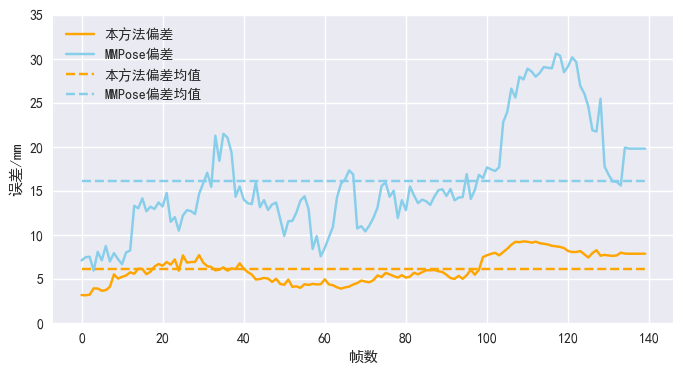

In [63]:
a = err_we.mean(axis=1)
plt.rcParams['font.sans-serif'] = ['SimHei']  # 适用于 Windows
# plt.rcParams['font.sans-serif'] = ['Arial Unicode MS']  # 适用于 macOS
plt.rcParams['axes.unicode_minus'] = False
plt.figure(figsize=(8,4))
plt.plot(range(140), 10*a, c='orange')
plt.plot(range(140), 10*b[:140], c='skyblue')
plt.plot(range(140), [10*a.mean()]*140, linestyle='--', c='orange')
plt.plot(range(140), [10*b.mean()]*140, linestyle='--', c='skyblue')
plt.ylabel('误差/mm')
plt.xlabel('帧数')
plt.legend(['本方法偏差','MMPose偏差','本方法偏差均值','MMPose偏差均值'])
plt.ylim([0,35])
plt.savefig('visss/lastsum.png', dpi=200)

In [40]:
xyz, err = world_all_mmpose()
err.mean()*10

16.071812310045903

In [41]:
err

array([[0.21948281, 0.7718958 , 0.62850744, ..., 1.12092974, 1.26967617,
        0.77975941],
       [0.22694133, 0.97660585, 0.67784413, ..., 1.11028985, 1.25419995,
        0.7647067 ],
       [0.2319443 , 0.99365102, 0.69156925, ..., 1.08070894, 1.21058712,
        0.72270966],
       ...,
       [2.29157928, 1.03903332, 1.23132693, ..., 0.56101621, 0.62724572,
        5.3880818 ],
       [2.2904512 , 1.03807098, 1.23253965, ..., 0.56101621, 0.62724572,
        5.3880818 ],
       [2.29159873, 1.03905006, 1.23130618, ..., 0.56101621, 0.62724572,
        5.3880818 ]])

In [36]:
xyz[:,:,2]

array([[ 3.03998508,  4.77909386,  3.84745339, ..., -0.64504623,
        -0.56574917,  0.14435863],
       [ 2.67798752,  4.31029626,  3.84728098, ..., -0.64000845,
        -0.5607338 ,  0.1423769 ],
       [ 2.68494189,  4.31748697,  3.85529894, ..., -0.62587404,
        -0.54666233,  0.13681149],
       ...,
       [ 4.33251135,  5.37389618,  6.17762379, ..., -0.3772049 ,
        -0.52999568,  0.37281179],
       [ 4.33251135,  5.37380427,  6.17762379, ..., -0.3772049 ,
        -0.52999568,  0.37281179],
       [ 4.33251135,  5.37389779,  6.17762379, ..., -0.3772049 ,
        -0.52999568,  0.37281179]])

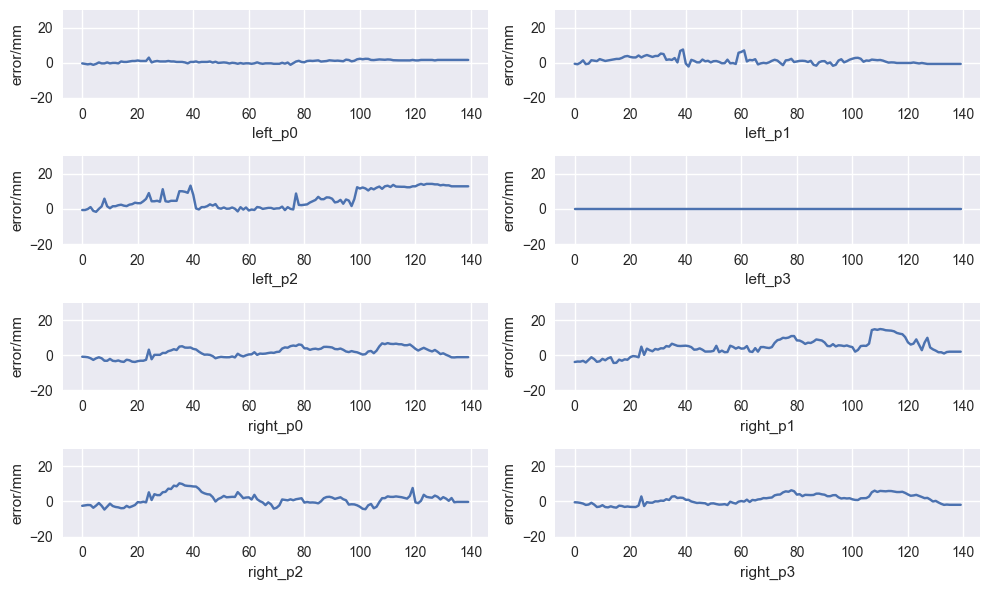

In [5]:
# plt.figure(figsize=(10,4))
# plt.title("World Position Error depth")
# plt.subplots(4,2)
plt.style.use('seaborn-v0_8')
plt.figure(figsize=(10,6))
names = ['left_p0', 'left_p1', 'left_p2', 'left_p3', 'right_p0', 'right_p1', 'right_p2', 'right_p3']
for ii in range(8):
    plt.subplot(4,2,ii+1)

    plt.plot(range(140), 10*xyz[:,ii, 2])
    plt.grid(True)
    plt.ylim([-20,30])
    plt.xlabel(names[ii])
    plt.ylabel('error/mm')
# plt.grid(False)
plt.tight_layout()
# plt.savefig("visss/err_depth_plot.png", dpi=300)

In [105]:
err.shape

(140, 8)

(0.0, 20.0)

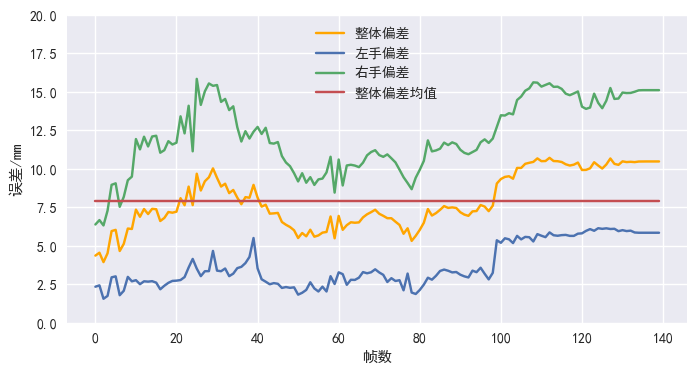

In [7]:
plt.rcParams['font.sans-serif'] = ['SimHei']  # 适用于 Windows
# plt.rcParams['font.sans-serif'] = ['Arial Unicode MS']  # 适用于 macOS
plt.rcParams['axes.unicode_minus'] = False
plt.figure(figsize=(8,4))
plt.plot(range(140), 10*err.mean(axis=1), c='orange')
plt.plot(range(140), 10*err[:,:4].mean(axis=1))
plt.plot(range(140), 10*err[:,4:].mean(axis=1))
plt.plot(range(140), [10*err.mean()]*140)
plt.ylabel('误差/mm')
plt.xlabel('帧数')
plt.legend(['整体偏差','左手偏差','右手偏差','整体偏差均值'])
plt.ylim([0,20])
# plt.savefig('visss/lastsum.png', dpi=200)

In [6]:
10*err.mean()

7.9124351523391665

In [21]:
10*err.mean()

7.9124351523391665

In [1]:
import cv2
import numpy as np

In [ ]:
img = np.zeros((480, 640), np.uint8)
cv2.imshow('img', img)
cv2.waitKey(0)